In [306]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
import scipy as scipy
from scipy.optimize import minimize

BACKTEST = 3 # years, recommend at least 1~3 years
LOWER_BOUND = 0 #increase for diversification 
UPPER_BOUND = 0.3
NUM_OF_SIMULATIONS = 5000 #for monte carlo simulation
SEED = 1300000 #a principal of 1,300,000KRW
lambda_penalty = 0.5 #increase for robustness & diversificaiton, try 0.1 ~ 10

In [307]:
endDate = dt.datetime.today() + dt.timedelta(hours = 9) #한국 시간 기준
startDate = endDate - dt.timedelta(days = 365 * BACKTEST)

# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS', 'NVDA', 'AVGO', 'WMT', 'LLY', 'JPM']
tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']

In [308]:
#stock = yf.Ticker("379800.KS") #개별주 시장가 확인
stock = yf.Ticker("KRW=X") #환율
price = stock.info['regularMarketPrice']
print(stock.info['currency'] + " " + str(price))

KRW 1395.56


In [309]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

               379800.KS     379810.KS      BTC-KRW     047810.KS  \
Date                                                                
2022-05-11  11320.023438  10441.497070   37014340.0  45153.164062   
2022-05-12  11180.454102  10127.053711   37496288.0  45446.687500   
2022-05-13  11235.285156  10211.903320   37440352.0  46278.324219   
2022-05-16  11315.038086  10331.691406   38250512.0  46669.683594   
2022-05-17  11329.992188  10336.682617   38542260.0  46816.445312   
2022-05-18  11394.791992  10416.541016   36642900.0  46278.324219   
2022-05-19  11060.824219   9997.284180   38306708.0  45642.363281   
2022-05-20  10986.054688   9987.301758   37194296.0  46278.324219   
2022-05-23  11030.916016   9992.292969   36633928.0  47794.843750   
2022-05-24  10966.116211   9827.584961   37399104.0  47207.804688   
2022-05-25  11035.901367   9837.567383   37446644.0  49604.882812   
2022-05-26  11100.701172   9887.478516   36873488.0  50191.925781   
2022-05-27  11235.285156  10082.13

In [310]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [311]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

           379800.KS  379810.KS   BTC-KRW  047810.KS  012450.KS      AAPL  \
379800.KS   0.030886   0.037774  0.020225   0.010098   0.015105  0.003251   
379810.KS   0.037774   0.052415  0.025029   0.011639   0.018583  0.005729   
BTC-KRW     0.020225   0.025029  0.281048   0.001554   0.004966  0.023841   
047810.KS   0.010098   0.011639  0.001554   0.173593   0.121277  0.001356   
012450.KS   0.015105   0.018583  0.004966   0.121277   0.325590 -0.004247   
AAPL        0.003251   0.005729  0.023841   0.001356  -0.004247  0.090379   
MSFT        0.002589   0.006475  0.029464   0.005866   0.001463  0.052633   
NVDA        0.004330   0.011995  0.034981   0.000043  -0.007783  0.081031   
GOOG        0.000440   0.003659  0.034573   0.007568  -0.003977  0.063557   
AMZN        0.003971   0.008110  0.028842  -0.000350   0.000364  0.065725   
META        0.000521   0.006536  0.023419  -0.008426  -0.005659  0.073259   
BRK-B       0.003706   0.003566  0.012275   0.008209   0.006137  0.031023   

In [312]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [313]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [314]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [ ]:
from fredapi import Fred
#https://fredaccount.stlouisfed.org/apikey
fred = Fred(api_key = '')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate[-1]
# print(risk_free_rate)

/tmp/ipykernel_17051/3437368303.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = ten_year_treasury_rate[-1]


In [316]:
#핵심
#OPTIMIZE the portfolio using different techniques here like
# monte carlo simulation, mathematical optimization, etc
# other alternatives include black-litterman model, min variance, 
# max diversification/risk pairty, 

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate) + (lambda_penalty * np.sum(weights**2))

# constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

#say you wanna fix AVGO's weight to be exactly 0.25. if you want it to be at least 0.25, change 'eq' to 'ineq'
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, 
              {'type': 'eq', 'fun': lambda weights: weights[tickers.index('379800.KS')] - 0.75}]
bounds = [(LOWER_BOUND, UPPER_BOUND) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [317]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [318]:
optimal_weights = optimized_results.x #.x gets the results

In [319]:
# print("Optimal Weights:")
# for ticker, weight in zip(tickers, optimal_weights):
#     print(f"{ticker}: {weight:.4f}")

# optimal_portfolio_return = expected_return(optimal_weights, log_returns)
# optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
# optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

# print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
# print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
# print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

In [320]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.bar(tickers, optimal_weights)

# plt.xlabel('Assets')
# plt.ylabel('Optimal Weights')
# plt.title('Optimal Portfolio Weights')

# plt.show()

In [321]:
# Initialize the components, to run a Monte Carlo Simulation.
number_of_symbols = len(tickers)
# We will run 5000 iterations.
num_of_portfolios = NUM_OF_SIMULATIONS

float_formatter = "{:.2f}".format

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_returns.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio

simulations_data = [ret_arr, vol_arr, sharpe_arr, np.round(all_weights, 4)]
# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

data = {
    'Portfolio Weights': [
        np.random.rand(10).tolist() for _ in range(5000)
    ]
}
df = pd.DataFrame(data)

# Set Pandas to display all columns and rows
pd.set_option('display.max_rows', None)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.max_colwidth', None)  # To prevent truncation of column values

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
MAX_LINE = 100
# print('')
# print('='*MAX_LINE)
# print('SIMULATIONS RESULT:')
# print('-'*MAX_LINE)
# with np.printoptions(threshold=sys.maxsize):
#     print(simulations_df)
# print('-'*MAX_LINE)

In [322]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]
monte_carlo_max_sharpe_weights = max_sharpe_ratio.loc['Portfolio Weights']
# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]
monte_carlo_min_vol_weights = min_volatility.loc['Portfolio Weights']

print('')
print('='*MAX_LINE)
print('MAX SHARPE RATIO:')
print('-'*MAX_LINE)
print(max_sharpe_ratio)
print('-'*MAX_LINE)

print('')
print('='*MAX_LINE)
print('MIN VOLATILITY:')
print('-'*MAX_LINE)
print(min_volatility)
print('-'*MAX_LINE)


MAX SHARPE RATIO:
----------------------------------------------------------------------------------------------------
Returns                                                                                                                                              0.367411
Volatility                                                                                                                                           0.171874
Sharpe Ratio                                                                                                                                         2.137677
Portfolio Weights    [0.1416, 0.0574, 0.0705, 0.0088, 0.1108, 0.0311, 0.0386, 0.0909, 0.0168, 0.0125, 0.0261, 0.0776, 0.0066, 0.0209, 0.1021, 0.0432, 0.1447]
Name: 4670, dtype: object
----------------------------------------------------------------------------------------------------

MIN VOLATILITY:
----------------------------------------------------------------------------------------------------
Ret

Re-reun SLSQP Optimization with weights from Monte Carlo simulation as initial guess to land a global Sharpe Maximum and enhance results

In [323]:
optimized_results_max_sharpe = minimize(neg_sharpe_ratio, monte_carlo_max_sharpe_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimized_results_min_vol = minimize(neg_sharpe_ratio, monte_carlo_min_vol_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [324]:
optimal_weights = optimized_results_max_sharpe.x
# optimal_weights = optimized_results_min_vol.x

print("Optimal Weights (최적화 가중치):")
print("원금: " + f"{SEED:,}"+ "원. 백테스팅 기간: " + F"{BACKTEST}" + "년")
for ticker, weight in zip(tickers, optimal_weights):
    num = round(SEED * weight)
    print(f"{ticker}: {weight:.4f}" + ", 원금기준 투자금액: " +  str(f"{num:,}") + "원")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights (최적화 가중치):
원금: 1,300,000원. 백테스팅 기간: 3년
379800.KS: 0.3000, 원금기준 투자금액: 390,000원
379810.KS: 0.0000, 원금기준 투자금액: 0원
BTC-KRW: 0.0656, 원금기준 투자금액: 85,285원
047810.KS: 0.0000, 원금기준 투자금액: 0원
012450.KS: 0.1672, 원금기준 투자금액: 217,319원
AAPL: 0.0000, 원금기준 투자금액: 0원
MSFT: 0.0000, 원금기준 투자금액: 0원
NVDA: 0.1220, 원금기준 투자금액: 158,655원
GOOG: 0.0000, 원금기준 투자금액: 0원
AMZN: 0.0000, 원금기준 투자금액: 0원
META: 0.0067, 원금기준 투자금액: 8,659원
BRK-B: 0.0000, 원금기준 투자금액: 0원
AVGO: 0.0466, 원금기준 투자금액: 60,608원
TSM: 0.0000, 원금기준 투자금액: 0원
WMT: 0.0537, 원금기준 투자금액: 69,781원
LLY: 0.1365, 원금기준 투자금액: 177,418원
JPM: 0.1019, 원금기준 투자금액: 132,466원
Expected Annual Return: 0.4251
Expected Volatility: 0.1815
Sharpe Ratio: 2.1066


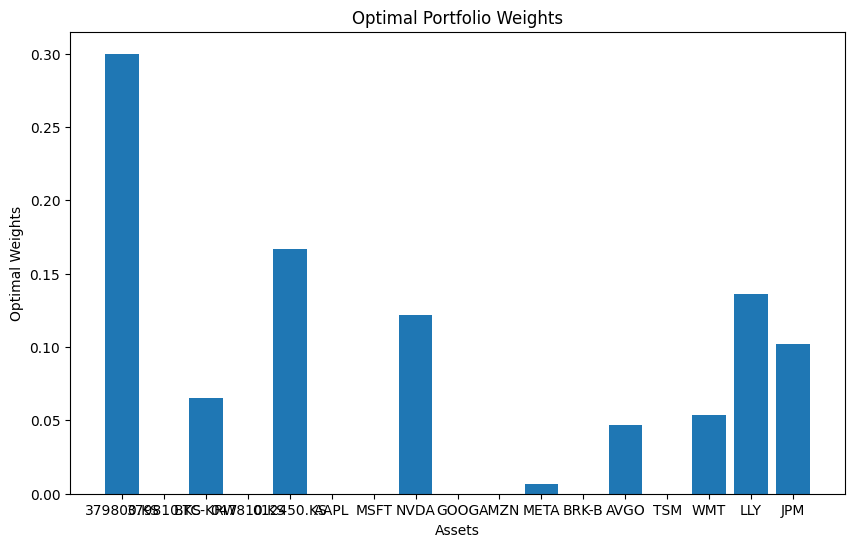

In [325]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()